In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [32]:
#Given Boundary Conditions
T_amb=27.0
T_o=250.0
k=0.45

In [33]:
def create_model():
    model ={
        'dense1':tf.keras.layers.Dense(50,activation='tanh'),
        'dense2':tf.keras.layers.Dense(50,activation='tanh'),
        'dense3':tf.keras.layers.Dense(50,activation='tanh'),
        'output':tf.keras.layers.Dense(1,dtype='float32')
    }
    return model

In [34]:
def call_model(model,t):
    t=model['dense1'](t)
    t=model['dense2'](t)
    t=model['dense3'](t)
    t=model['output'](t)
    return t


In [35]:
#Define the differential Equation
def pde(t, model):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        T_pred=call_model(model,t)
        T_t=tape.gradient(T_pred,t)
    del tape
    return T_t - k*(T_amb - T_pred )


In [36]:
def loss(model,t,t_ic,T_ic):
    f=pde(t,model)
    loss_pde=tf.reduce_mean(tf.square(f))
    T_ic_pred=call_model(model,t_ic)
    loss_ic=tf.reduce_mean(tf.square(T_ic-T_ic_pred))
    return loss_pde+loss_ic


In [ ]:
#Define the training step
@tf.function# Its a decorator that converts a regular python function into a tensorflow graph allowing it to be executed more effieciently
def train_step(model,t,t_ic,T_ic,optimizer):
    with tf.GradientTape() as tape:
        loss_value=loss(model,t,t_ic,T_ic)
        grads=tape.gradient(loss_value,[layer.trainable_variables for layer in model.values()])
        #flatten the list of trainable parameters
        grads=[grad for sublist in grads for grad in sublist]
        variables=[var for layer in model.values() for var in layer.trainable_variables]
        optimizer.apply_gradients(zip(grads,variables))
        return loss_value

In [39]:
#Generate training Data
t_train=np.linspace(0,10,100).reshape(-1,1)
t_train=tf.convert_to_tensor(t_train,dtype=tf.float32)

In [40]:
#Now the Initial Condition Data
t_ic=np.array([[0.0]],dtype=np.float32)
T_ic=np.array([[T_o]],dtype=np.float32)
t_ic=tf.convert_to_tensor(t_ic,dtype=tf.float32)
T_ic=tf.convert_to_tensor(T_ic,dtype=tf.float32)

In [41]:
model=create_model()

In [42]:
#Defining the optimizer with a learning rate scheduler
lr_schedule=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=500,
    decay_rate=0.95
)
optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [50]:
epochs=15000
for epoch in range (epochs):
    loss_value=train_step(model,t_train,t_ic,T_ic,optimizer)
    if epoch%500 == 0:
        print(f"Epoch {epoch} : Loss = {loss_value.numpy()}")


Epoch 0 : Loss = 3.3512689697090536e-05
Epoch 500 : Loss = 3.7592115404549986e-05
Epoch 1000 : Loss = 2.860466884158086e-05
Epoch 1500 : Loss = 2.647905785124749e-05
Epoch 2000 : Loss = 0.0001167304435512051
Epoch 2500 : Loss = 2.310885065526236e-05
Epoch 3000 : Loss = 2.4657996618770994e-05
Epoch 3500 : Loss = 2.032479278568644e-05
Epoch 4000 : Loss = 1.9044142391066998e-05
Epoch 4500 : Loss = 1.8152526536141522e-05
Epoch 5000 : Loss = 1.7089761968236417e-05
Epoch 5500 : Loss = 1.636808883631602e-05
Epoch 6000 : Loss = 0.001736571779474616
Epoch 6500 : Loss = 1.4840580661257263e-05
Epoch 7000 : Loss = 1.4171375369187444e-05
Epoch 7500 : Loss = 1.3530667274608277e-05
Epoch 8000 : Loss = 1.297079688811209e-05
Epoch 8500 : Loss = 1.2432233233994339e-05
Epoch 9000 : Loss = 1.1897355761902872e-05
Epoch 9500 : Loss = 1.1360493772372138e-05
Epoch 10000 : Loss = 1.0919731721514836e-05
Epoch 10500 : Loss = 1.0449484761920758e-05
Epoch 11000 : Loss = 1.0085454960062634e-05
Epoch 11500 : Loss = 

In [51]:
#Predicting the solution
t_test=np.linspace(0,10,100).reshape(-1,1)
t_test=tf.convert_to_tensor(t_test,dtype=tf.float32)
T_pred=call_model(model,t_test).numpy()
#Analytical Solution
T_true =T_amb+(T_o-T_amb)*np.exp(-(k*t_test))

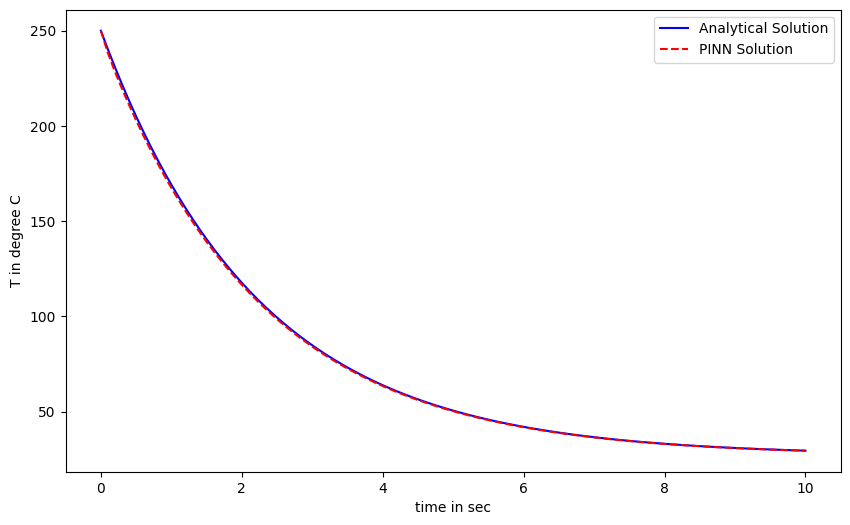

In [52]:
plt.figure(figsize=(10,6))
plt.plot(t_test,T_true,'b-',label='Analytical Solution')
plt.plot(t_test,T_pred,'r--',label='PINN Solution')
plt.xlabel('time in sec')
plt.ylabel('T in degree C')
plt.legend()